In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
import os
import glob
import cv2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from matplotlib import pyplot as plt
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from sklearn.metrics import accuracy_score

In [3]:
image_path = os.path.join(r"D:\xray-chest\yolov5-master\Lung Segmentation\CXR_png")
mask_path = os.path.join(r"D:\xray-chest\yolov5-master\Lung Segmentation\masks")
images = os.listdir(image_path)
mask = os.listdir(mask_path)
print(len(images), len(mask))


800 704


In [4]:
mask2 = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask2]
print(len(image_file_name), len(mask))

704 704


In [5]:
check = [i for i in mask if "mask" in i]
print(len(check))

566


In [6]:
dsize = (256, 256)
def image_resize(img):
    return cv2.resize(img,dsize )

In [7]:
#print(mask)
x = np.array([np.array(np.stack(( image_resize(cv2.imread(os.path.join(image_path,filename.split("_mask")[0]+".png"),  0)),), axis=-1)) for filename in image_file_name])
y= np.array([np.array(np.stack(( image_resize(cv2.imread(os.path.join(mask_path,filename),  0)),), axis=-1)) for filename in mask])

In [8]:
print(x.shape, y.shape)

(704, 256, 256, 1) (704, 256, 256, 1)


In [9]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    x = x[indices]
    y = y[indices]
    p = p[indices]
    dsize2 =(400,400)
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(x[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()    
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(y[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()    
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        xi = cv2.resize(p[i], dsize2)
        plt.imshow(xi)
        plt.xticks([])
        plt.yticks([])
#        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
#        plt.xlabel(class_names[np.argmax(p[i])], color=col)
    plt.show()   

(1126, 256, 256, 1) (1126, 256, 256, 1)


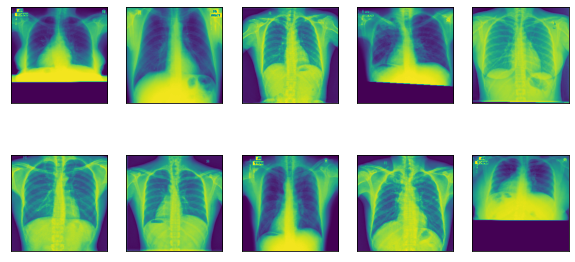

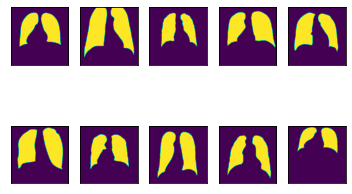

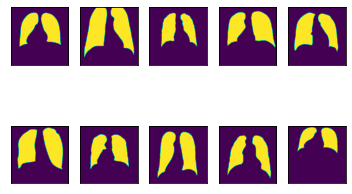

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_m, y_test_m = train_test_split(x, y, test_size=0.2, random_state=123)
x2 = np.flip(X_train , axis = 2)
y2 = np.flip(y_train_m , axis = 2)
X_train= np.append(X_train, x2,axis=0)
y_train_m = np.append(y_train_m, y2,axis=0)
print(X_train.shape,y_train_m.shape )
show_random_examples(X_train, y_train_m, y_train_m)

In [16]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

   # if(pretrained_weights):
    #    model.load_weights(pretrained_weights)

    return model

In [17]:
model_1 = unet()
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_25[0][0]                  
____________________________________________________________________________________________

In [13]:
y_test_m2 = (y_test_m/255.> .5).astype(int)

In [20]:
y_train_m2 = (y_train_m/255.> .5).astype(int)

h = model_1.fit(
    X_train/255., y_train_m2,   
    callbacks=None,
    validation_data=(X_test/255., y_test_m2),
    epochs=10, batch_size=6,
    validation_split=0.2,
    shuffle=True,
)

Epoch 1/10
150/150 [==============================] - 207s 1s/step - loss: 12.4010 - accuracy: 0.8168 - val_loss: 0.3204 - val_accuracy: 0.8928
Epoch 2/10
150/150 [==============================] - 183s 1s/step - loss: 0.2223 - accuracy: 0.9577 - val_loss: 0.2442 - val_accuracy: 0.9330
Epoch 3/10
150/150 [==============================] - 185s 1s/step - loss: 0.1974 - accuracy: 0.9660 - val_loss: 0.2225 - val_accuracy: 0.9442
Epoch 4/10
150/150 [==============================] - 187s 1s/step - loss: 0.1828 - accuracy: 0.9677 - val_loss: 0.2462 - val_accuracy: 0.9158
Epoch 5/10
150/150 [==============================] - 188s 1s/step - loss: 0.1704 - accuracy: 0.9696 - val_loss: 0.1854 - val_accuracy: 0.9579
Epoch 6/10
150/150 [==============================] - 189s 1s/step - loss: 0.1585 - accuracy: 0.9711 - val_loss: 0.1486 - val_accuracy: 0.9743
Epoch 7/10
150/150 [==============================] - 190s 1s/step - loss: 0.1498 - accuracy: 0.9718 - val_loss: 0.1822 - val_accuracy: 0.951

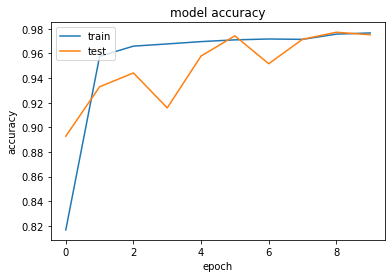

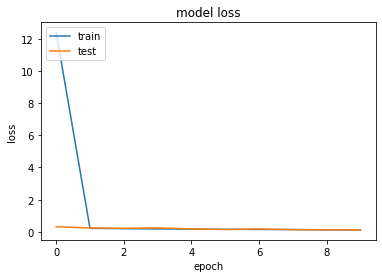

In [27]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


losses = h.history['loss']
accs = h.history['accuracy']
val_losses = h.history['val_loss']
val_accs = h.history['val_accuracy']
epochs = len(losses)

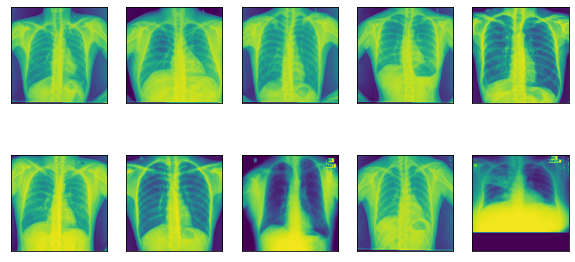

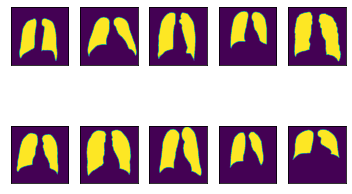

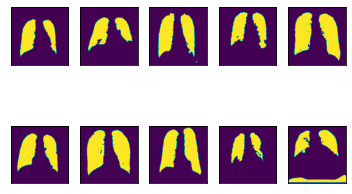

In [32]:
preds = model_1.predict(X_test, batch_size = 5)

show_random_examples(X_test, y_test_m, preds)

In [34]:
test_path = os.path.join(r"D:\xray-chest\yolov5-master\Lung Segmentation\test")
test = os.listdir(test_path)
#print(test)
y= np.array([np.array(np.stack(( image_resize(cv2.imread(os.path.join(test_path,filename),  0)),), axis=-1)) for filename in test])

preds3 = model_1.predict(y/255., batch_size = 5)*255


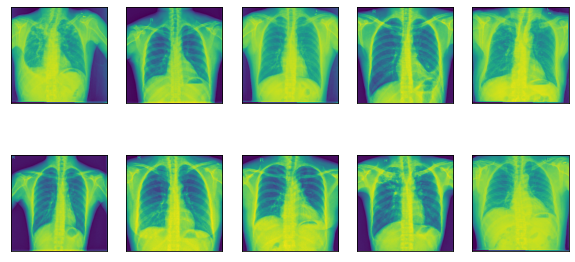

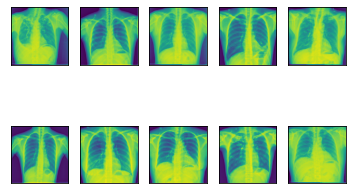

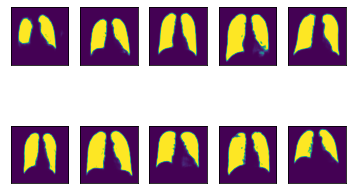

In [37]:
show_random_examples(y, y, preds3)